In [3]:
# import required libraries 

In [99]:
#@title

# !pip install deepxde
import deepxde as dde 
import tensorflow as tf
import numpy as np
from numpy import pi, sin , linspace ,cos,exp,zeros, array
import pandas as pd
import matplotlib.pyplot as plt 


from numpy import zeros, zeros_like, double, linspace, meshgrid, dot, exp, max, abs, append, sqrt, log
from scipy.stats import norm
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc ## Needed for animation
import warnings 

warnings.filterwarnings('ignore')
import sys

In [76]:
# Functions Used

In [84]:
#@title


def F(x : float ) -> float :
  return   (pi**2)*tf.cos(pi*x)*tf.sin(pi*x)

def A(x : float ) -> float : 
  return 1

def B(x : float) -> float : 
  return pi*tf.sin(pi*x)

def C(x : float ) -> float : 
  return  pi**2  

def actual_sol(x):
  return sin(pi * x)

def bdry(x):
  return actual_sol(x)

# specify PDE 
def pde( x , y ) :
  dy_xx = dde.grad.hessian( y , x ,i=0,j=0) 
  dy_x = dde.grad.jacobian(y,x,i=0,j=0)  
  ans = A(x)*dy_xx + B(x)*dy_x + C(x)*y - F(x) 
  return [ans]

In [79]:
# bvp solution using deepxde library     bvp_solver(xL,xR,bdry, n_domain,n_boundary,n_test,n_hidden_layers,hidden_layer_neurons,epochs) - Time indpendent differential equation

In [80]:
#@title
def  bvp_solver(xL,xR,bdry, n_domain,n_boundary,n_test,n_hidden_layers,hidden_layer_neurons,epochs) : 

    # specify domain 
    domain = dde.geometry.Interval(xL,xR)

    # specify boundary 
    def is_boundaryPoint(_,boolean):
      return boolean

    def boundaryVal(x):
      boundary = bdry(x) 
      return boundary 

    #define dirichlet boundary condition
    bc = dde.DirichletBC(domain, boundaryVal, is_boundaryPoint)

    # PDE solver 
    data = dde.data.PDE(domain, pde, bc ,solution = actual_sol, num_domain=n_domain, num_boundary=n_boundary, num_test=n_test)

    # set up neural network 
    layer_size = [1] + [hidden_layer_neurons] *n_hidden_layers  + [1]    # input layer - 1  -> hidden layers ->  output layer- 1 neuron
    activation_func =  'tanh'   # other options ['linear'(default), elu','relu','selu', 'sigmoid','swish'] 
    initializer =  'Glorot normal'  # to generate random intial values for weight vector  # mean=0 , stddev = 1.0

    NN = dde.maps.FNN(layer_size, activation=activation_func, kernel_initializer = initializer)

    # model 
    model = dde.Model(data,NN)

    optimizer = "adam"  
    # other options 
    # ["BFGS", "L-BFGS-B", "Nelder-Mead", "Powell", "CG", "Newton-CG"]
    #  "sgd": tf.train.GradientDescentOptimizer(lr),
    # "sgdnesterov": tf.train.MomentumOptimizer(lr, 0.9, use_nesterov=True),
    # "adagrad": tf.train.AdagradOptimizer(0.01),
    # "adadelta": tf.train.AdadeltaOptimizer(),
    # "rmsprop": tf.train.RMSPropOptimizer(lr),
    # "adam": tf.train.AdamOptimizer(lr),

    lr = 0.01
    metric = ["l2 relative error"]
    model.compile(optimizer = optimizer,lr=lr,metrics=metric)  
    #train model 
    model.train(epochs, disregard_previous_best = True)

    return model 


#---------------------------------------------------------------------------------------------------------------------------------------------
# train_loss_shape = len(shape_output_returned_from_pde) + len(shape_boundary_conditions)
# test_loss_shape = len(shape_output_returned_from_pde) +  len(shape_boundary_conditions)   # here boundary conditions errrors are set to tf.constant(0) 
#---------------------------------------------------------------------------------------------------------------------------------------------

In [81]:
# Plot Solution

In [82]:
#@title
def plot_solution(model, x) :
    figure,axis = plt.subplots(1,2,figsize=(15,5))
    x = x.reshape(len(x),1)
    y = model.predict(x).reshape(-1)
    print(np.shape(x),np.shape(y))
    
    y_true = actual_sol(x).reshape(-1)
    axis[0].plot(x,y,label = 'prediction')
    axis[0].plot(x,y_true,label = 'actual sol')
    axis[0].legend(loc='upper left')
    axis[0].title.set_text('Predicted Y')

    errors = abs(y_true-y)
    axis[1].plot(x,errors)
    axis[1].title.set_text('Error in prediction')


 ### Example 1
\begin{align}
&A(x)\frac{\partial^2 u(x)}{\partial x^2} + B(x)\frac{\partial u(x)}{\partial x} + C(x)u(x) = F(x) & &A(x)>0&  &B(x) !=0 &  
\end{align}

In [74]:
# input parameters 
xL = 0 ; xR = 1 ; uL = 0 ; uR = 0 
num_domain = 200
num_boundary = 2
num_test = 200
n_hidden_layers = 1
hidden_layer_neurons = 70
epochs = 10000
M = 100
x = linspace(xL,xR,M+1)
x = x.reshape((len(x),1))

model = bvp_solver(xL,xR,bdry, num_domain,num_boundary,num_test,n_hidden_layers,hidden_layer_neurons,epochs)


Compiling model...
Building feed-forward neural network...
'build' took 0.033573 s

'compile' took 0.900126 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric   
0         [2.43e+01, 4.51e-03]    [2.43e+01, 0.00e+00]    [9.40e-01]    
1000      [1.32e-01, 1.39e-01]    [1.31e-01, 0.00e+00]    [5.98e-01]    
2000      [2.93e-01, 5.67e-02]    [2.89e-01, 0.00e+00]    [5.60e-01]    
3000      [1.58e-02, 1.78e-02]    [1.57e-02, 0.00e+00]    [1.00e+00]    
4000      [1.17e-02, 1.56e-02]    [1.16e-02, 0.00e+00]    [9.36e-01]    
5000      [9.55e-03, 1.31e-02]    [9.47e-03, 0.00e+00]    [8.61e-01]    
6000      [8.32e-03, 1.18e-02]    [8.25e-03, 0.00e+00]    [8.20e-01]    
7000      [6.93e-03, 1.06e-02]    [6.85e-03, 0.00e+00]    [7.75e-01]    
8000      [5.48e-03, 9.00e-03]    [5.39e-03, 0.00e+00]    [7.14e-01]    
9000      [4.56e-03, 6.65e-03]    [4.46e-03, 0.00e+00]    [6.14e-01]    
10000     [5.24e-03, 4.34e-03]    [5.17e-

**[ Case 1 ]**  -->  A(x) = 1,  B(x)=π ,    C(x) = π^2 ,   F(x) = π^2 cos(πx) 

(101, 1) (101,)


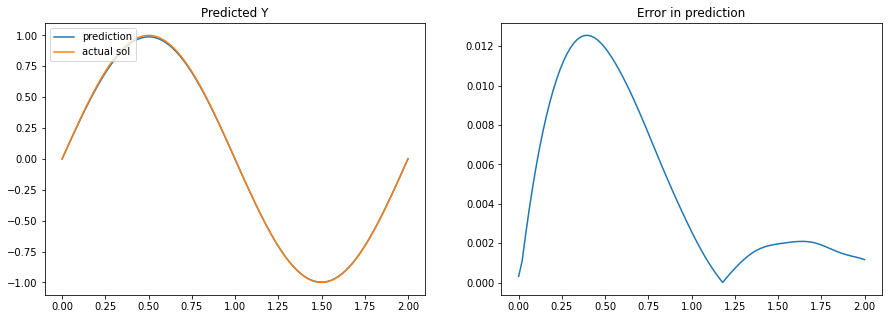

In [34]:
plot_solution(model,x)

**[ Case 2 ]**  -->  A(x) = x,  B(x)=π ,    C(x) = x*(π^2) ,   F(x) = π^2 cos(πx)

In [36]:
#@title

# input parameters 
xL = 0 ; xR = 2 ; uL = 0 ; uR = 0 
num_domain = 200
num_boundary = 2
num_test = 100
n_hidden_layers = 2
hidden_layer_neurons = 20
epochs = 10000
M = 100
x = linspace(xL,xR,M+1)
x = x.reshape((len(x),1))

model = bvp_solver(xL,xR,bdry, num_domain,num_boundary,num_test,n_hidden_layers,hidden_layer_neurons,epochs)

Compiling model...
Building feed-forward neural network...
'build' took 0.045964 s

'compile' took 0.657814 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric   
0         [6.89e+01, 7.09e-02]    [7.01e+01, 0.00e+00]    [9.38e-01]    
1000      [1.90e-03, 9.48e-07]    [2.23e-03, 0.00e+00]    [1.27e-03]    
2000      [5.31e-04, 4.71e-08]    [5.87e-04, 0.00e+00]    [3.18e-04]    
3000      [4.53e-04, 1.61e-07]    [4.86e-04, 0.00e+00]    [4.98e-04]    
4000      [4.98e-01, 3.77e-03]    [4.96e-01, 0.00e+00]    [5.50e-02]    
5000      [8.01e-04, 5.95e-06]    [8.26e-04, 0.00e+00]    [2.64e-03]    
6000      [1.18e-04, 1.63e-08]    [1.33e-04, 0.00e+00]    [1.98e-04]    
7000      [6.50e-05, 2.22e-09]    [7.58e-05, 0.00e+00]    [1.29e-04]    
8000      [5.36e-05, 1.82e-09]    [6.11e-05, 0.00e+00]    [1.07e-04]    
9000      [8.32e-05, 5.01e-08]    [8.88e-05, 0.00e+00]    [2.64e-04]    
10000     [7.78e-02, 7.18e-04]    [7.71e-

(101, 1) (101,)


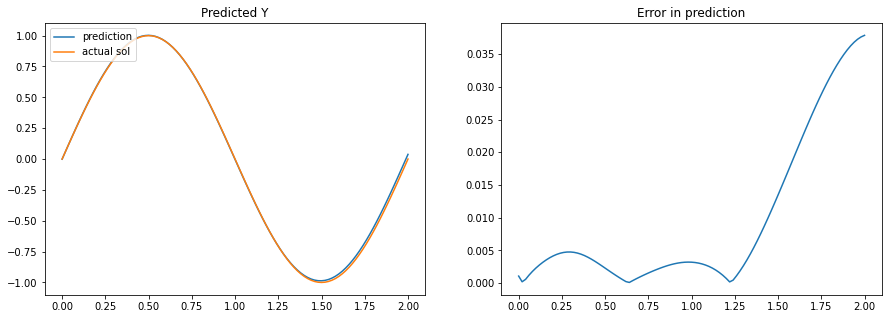

In [38]:
plot_solution(model,x)

**[ Case 3 ]**  -->  A(x) = 1,  B(x)=π*x ,    C(x) = (π^2) ,   F(x) = π^2 * x * cos(πx)

In [58]:
#@title

# input parameters 
xL = 0 ; xR = 1 ; uL = 0 ; uR = 0 
num_domain = 100
num_boundary = 2
num_test = 100
n_hidden_layers = 1
hidden_layer_neurons = 40 
epochs = 10000
M = 100
x = linspace(xL,xR,M+1)
x = x.reshape((len(x),1))
model = bvp_solver(xL,xR,bdry, num_domain,num_boundary,num_test,n_hidden_layers,hidden_layer_neurons,epochs)

Compiling model...
Building feed-forward neural network...
'build' took 0.039851 s

'compile' took 0.596620 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric   
0         [6.48e+01, 1.20e-02]    [6.46e+01, 0.00e+00]    [1.05e+00]    
1000      [3.05e-01, 2.39e-02]    [2.95e-01, 0.00e+00]    [4.29e-01]    
2000      [1.09e-01, 1.68e-03]    [1.01e-01, 0.00e+00]    [4.84e-01]    
3000      [6.82e-02, 1.68e-03]    [6.21e-02, 0.00e+00]    [5.32e-01]    
4000      [4.30e-02, 2.52e-03]    [3.91e-02, 0.00e+00]    [6.29e-01]    
5000      [3.14e-02, 3.73e-03]    [2.87e-02, 0.00e+00]    [7.50e-01]    
6000      [2.59e-02, 4.17e-03]    [2.38e-02, 0.00e+00]    [7.88e-01]    
7000      [2.25e-02, 3.94e-03]    [2.09e-02, 0.00e+00]    [7.63e-01]    
8000      [2.00e-02, 3.52e-03]    [1.87e-02, 0.00e+00]    [7.26e-01]    
9000      [1.74e-02, 3.25e-03]    [1.63e-02, 0.00e+00]    [6.91e-01]    
10000     [1.55e-02, 2.97e-03]    [1.46e-

(101, 1) (101,)


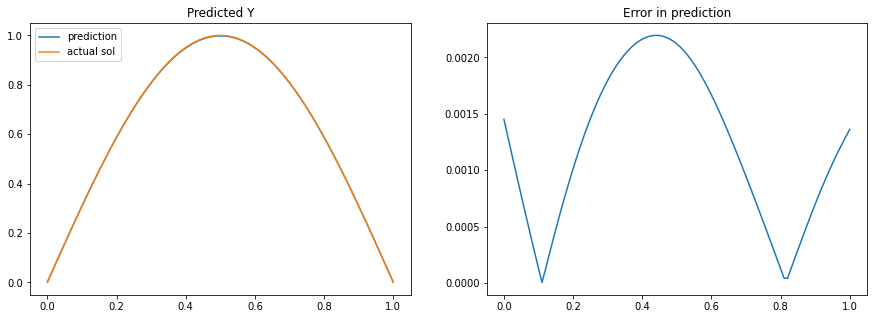

In [75]:
plot_solution( model, x )

**[ Case 4 ]**  -->  A(x) = 1,  B(x)=πsin(x) ,    C(x) = (π^2) ,   F(x) = π^2 sin(x)cos(πx)

In [85]:
# input parameters 
xL = 0 ; xR = 2 ; uL = 0 ; uR = 0 
num_domain = 200
num_boundary = 2
num_test = 100
n_hidden_layers = 2
hidden_layer_neurons = 20
epochs = 10000
M = 100
x = linspace(xL,xR,M+1)
x = x.reshape((len(x),1))

model = bvp_solver(xL,xR,bdry, num_domain,num_boundary,num_test,n_hidden_layers,hidden_layer_neurons,epochs)

Compiling model...
Building feed-forward neural network...
'build' took 0.050474 s

'compile' took 1.073777 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric   
0         [1.85e+01, 1.31e-01]    [1.83e+01, 0.00e+00]    [9.51e-01]    
1000      [7.65e-03, 5.43e-03]    [7.70e-03, 0.00e+00]    [1.98e-01]    
2000      [2.34e-03, 8.25e-04]    [2.38e-03, 0.00e+00]    [7.91e-02]    
3000      [4.97e-01, 1.01e-03]    [4.91e-01, 0.00e+00]    [9.17e-02]    
4000      [9.76e-04, 1.02e-04]    [1.02e-03, 0.00e+00]    [2.84e-02]    
5000      [7.70e-04, 6.90e-05]    [8.03e-04, 0.00e+00]    [2.33e-02]    
6000      [6.27e-04, 3.93e-05]    [6.55e-04, 0.00e+00]    [1.77e-02]    
7000      [5.08e-04, 1.63e-05]    [5.34e-04, 0.00e+00]    [1.15e-02]    
8000      [4.29e-04, 2.03e-05]    [4.49e-04, 0.00e+00]    [1.27e-02]    
9000      [3.48e-04, 6.97e-06]    [3.67e-04, 0.00e+00]    [7.55e-03]    
10000     [2.74e-04, 6.66e-06]    [2.89e-

(101, 1) (101,)


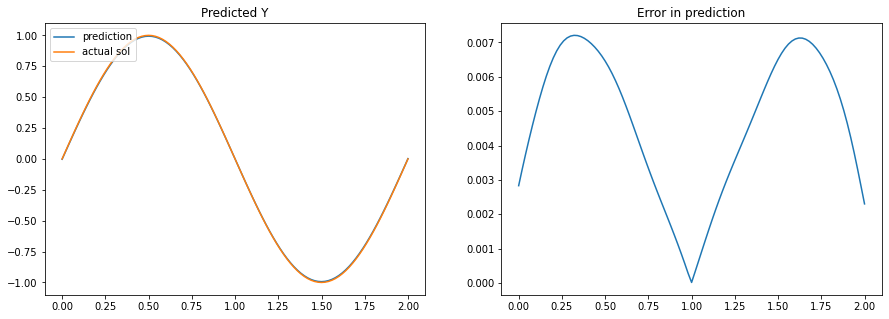

In [86]:
plot_solution(model,x)

### Black Scholes Model

In [103]:
# bvp_time_dependent_solver(xL,xR,T, n_domain,n_boundary,n_initial,n_hidden_layers,hidden_layer_neurons,epochs)

In [124]:

def  bvp_time_dependent_solver(xL,xR,T, n_domain,n_boundary,n_initial,n_hidden_layers,hidden_layer_neurons,epochs) : 

    # specify domain 
    spatial_domain = dde.geometry.Interval(xL,xR)
    temporal_domain = dde.geometry.TimeDomain(0,T)

    domain = dde.geometry.GeometryXTime(spatial_domain,temporal_domain)

    # specify boundary 
    def is_boundaryPoint(_,boolean):
      return boolean 

    def boundaryVal(x):
      bdry_vals = zeros((len(x),1))

      for i in range(len(x)):
        tmp =  K*(exp(x[i][0])-1)
        if (tmp > 0) : 
          bdry_vals[i] = tmp
          
      return bdry_vals 

    def is_InitialPoint(_,boolean) : 
      return boolean 

    #define dirichlet boundary condition
    bc = dde.DirichletBC(domain, boundaryVal, is_boundaryPoint)
    ic = dde.IC(domain, boundaryVal, is_InitialPoint)

    # PDE solver 
    data = dde.data.TimePDE(domain, pde, [bc,ic], num_domain=n_domain, num_boundary=n_boundary, num_initial=n_initial)

    # set up neural network 
    layer_size = [2] + [hidden_layer_neurons] *n_hidden_layers  + [1]    # input layer - 1  -> hidden layers ->  output layer- 1 neuron
    activation_func =  'tanh'   
    initializer =  'Glorot normal' 

    NN = dde.maps.FNN(layer_size, activation=activation_func, kernel_initializer = initializer)

    # model 
    model = dde.Model(data,NN)

    optimizer = "adam"  
    lr = 0.01
    model.compile(optimizer,lr=lr)  

    # train model 
    model.train(epochs, disregard_previous_best = True )

    return model 

In [125]:
# functions used 

def F(x : float ) -> float :
  return   0

def A(x : float ) -> float :
  return (-1/2)*sigma**2

def B(x : float) -> float : 
  return (1/2)*sigma**2 - r

def C(x : float ) -> float : 
  return  r

def Tt(x : float) -> float : 
  return 1 

# specify PDE 
def pde( x, y ) :  
  dy_xx = dde.grad.hessian( y , x ,i=0, j=0) 
  dy_x = dde.grad.jacobian(y,x,i=0,j=0)
  dy_t = dde.grad.jacobian(y,x,i=0,j=1)  
  return A(x)*dy_xx + B(x)*dy_x + C(x)*y + Tt(x)*dy_t - F(x) 

In [134]:

sigma = 0.2
r = 0.06
T = 1
K = 5
xL = -2
xR = 2
M = 16
N = 8
n_domain = 200
n_boundary = 20
n_initial = 10 
n_hidden_layers = 1
hidden_layer_neurons = 30
epochs = 10000

x = linspace(xL,xR, M+1)
t = linspace(0,T,N+1)

h = (xR - xL)/M 
k = T/N 

model = bvp_time_dependent_solver(xL,xR,T,n_domain,n_boundary, n_initial,n_hidden_layers,hidden_layer_neurons, epochs)

Compiling model...
Building feed-forward neural network...
'build' took 0.033215 s



TypeError: ignored

In [135]:
input_grid = []
for j in range(len(t)):
    tmp = []
    for i in range(len(x)):
      tmp.append([x[i],t[j]])
    input_grid.append(tmp)


sols = []
input_grid  = array(input_grid)

for input in input_grid : 
  sol = model.predict(input)
  sols.append(sol)

sols = array(sols).reshape(len(t),len(x))
sols.shape

(9, 17)

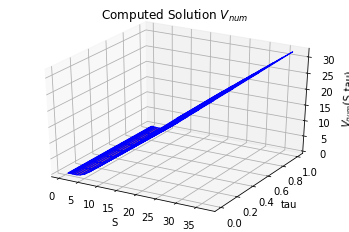

In [136]:
S = K*exp(x)
S = S.reshape(len(S),1)
tau = T-t[::-1] # Original financial variables
Vnum = sols[::-1,:].T

plt.clf() # clear existing figures
Tt, Ss = meshgrid(tau, S)
fig = plt.figure(1)
ax = plt.axes(projection='3d')
ax.plot_surface(Ss, Tt, Vnum, color='red',alpha = 0.5, linewidth=1, edgecolors='blue')
plt.axis('tight')
ax.set_xlabel('S')
ax.set_ylabel('tau')
ax.set_zlabel('$V_{num}$(S,tau)');
ax.set_title('Computed Solution $V_{num}$');

In [137]:
# for i in range(len(Vnum)):
#   print(*Vnum[i],sep=' ')

#### Analytical Solution $V(S_{\tau},\tau)\;(S_{\tau},\tau)\in[Ke^{x_{L}},Ke^{x_{R}}]\times [0,T]$

In [138]:
V = zeros((len(S),len(tau))) # Initialization of the option value
y = S-K
Y = append(arr=zeros((len(y),1)),values=y,axis=1) #Adding column of 1 to the matrix
V[:,-1] = max(Y,axis=1) # Option value at the maturity date T
## option value at (S(i),tau(n)), i =1,2,...,Nx+1, n = 1,2,...,Nt.
for i in range(0,len(x)):
    for n in range(len(t)-2,-1,-1): 
        d1 = (log(S[i]/K) + (r+0.5*sigma**2)*(T-tau[n]))/(sigma*sqrt(T-tau[n]))
        d2 = d1-sigma*sqrt(T-tau[n])
        V[i,n] = S[i]*norm.cdf(d1) - K*exp(-r*(T-tau[n]))*norm.cdf(d2)


In [139]:
print(V.shape, Vnum.shape)

Errors = abs(V - Vnum)


(17, 9) (17, 9)


In [140]:
# Plot Errors

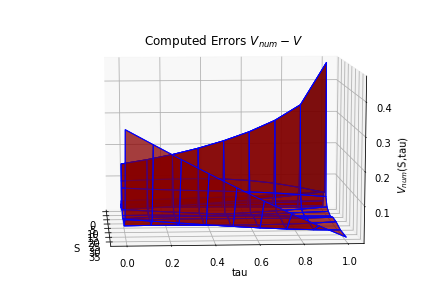

In [141]:
# Create a figure and a 3D Axes

fig = plt.figure()
ax = Axes3D(fig)

# init function initializes the data
def init():
    # Plot the surface.
    ax.plot_surface(Ss, Tt, Errors, color='red',alpha = 0.5,
                    linewidth=1, edgecolors='blue')
    plt.axis('tight')
    ax.set_xlabel('S')
    ax.set_ylabel('tau')
    ax.set_zlabel('$V_{num}$(S,tau)');
    ax.set_title('Computed Errors $V_{num} - V$');
    return fig,

def animate(i):
    # azimuth angle : 0 deg to 360 deg
    ax.view_init(elev=10, azim=i*4)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=90, interval=50, blit = False) 
# The blit parameter ensures that only those pieces of the plot are re-drawn which have been changed
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim